Motivaton:

Assume an SDE for a stock priced described as:

$$dS(t) = rS(t)dt + JS(t)dW^{Q}(t)$$

where J represents a certain stochastic volatily RV with some distirbution for example $J \sim N(\mu, \sigma^2)$

Using Ito's formula we can obtain 
$$ S(T) = S_{0}exp((r-\frac{J^{2}}{2})T+JW^{Q}(T))$$

We want to asses the European option:

$$E[max(S(T)-K,0)|F(t_{0})] = E[E[max(S(T)-K,0|J=j]|F(t_{0})]$$

Using the Tower property, we can rewrtie the expectation on the left to the one on the right. The inner expectation then simply become the general Black Scholes formula for a specific realisation of J.


The solution to the inner expectation becomes:

$$E[max(S(T)-K,0|J=j] = S(t_{0})e^{r(T-t_{0}）}F_{N(0,1)}(d_{1}) - KF_{N(0,1)}(d_{2})$$
$$d_{1} = \frac{log\frac{S(t_0)}{K}+(r+\frac{j^2}{2}(T-t_0))}{j\sqrt{(T-t_0)}}$$
$$d_{2} = d_{1} - j \sqrt{(T-t_0)}$$


Substitutiong into the main equation:
$$E[max(S(T)-K,0)|F(t_{0})] = S(t_{0})e^{r(T-t_{0}）}E[F_{N(0,1)}(d_{1})] - KE[F_{N(0,1)}(d_{2})] $$

In [52]:
import numpy as np
import matplotlib.pyplot as plt
import enum
import scipy.stats as st

In [53]:
# Define put and call options
class OptionType(enum.Enum):
    CALL = 1.0
    PUT = -1.0

In [54]:
def GeneratePaths(NoOfPaths, NoOfSteps,S0, T, muJ, sigmaJ, r):
    # Creating empty matrices
    X = np.zeros([NoOfPaths, NoOfSteps+1])
    S = np.zeros([NoOfPaths, NoOfSteps+1])
    time = np.zeros([NoOfSteps+1])

    dt = T/float(NoOfSteps)
    X[:,0] = np.log(S0)
    S[:,0] = S0

    Z = np.random.normal(0, 1, [NoOfPaths,NoOfSteps])
    J = np.random.normal(muJ, sigmaJ,[NoOfPaths,NoOfSteps])
    for i in range(0, NoOfSteps):
        if NoOfPaths > 1:
            Z[:,i] = (Z[:,i] - np.mean(Z[:,i]))/np.std(Z[:,i])
        X[:,i+1] = X[:,i] + (r - 0.5*J[:,i]**2)*dt + J[:,i]*np.sqrt(dt)*Z[:,i]
        time[i+1] = time[i] + dt

    S = np.exp(X)
    paths = {"time":time, "X":X, "S":S, "J":J}
    return paths

In [55]:
def EUOptionPriceFromMCPaths(CP,S,K,T,r):

    if CP == OptionType.CALL:
        return np.exp(-r*T)*np.mean(np.maximum(S-K,0))
    elif CP == OptionType.PUT:
        return np.exp(-r*T)*np.mean(np.maximum(K-S,0))

In [56]:
def BS_Call_Put_Option_Price(CP,S_0,K,sigma,t,T,r):
    K = np.array(K).reshape([len(K),1])
    d1 = (np.log(S_0/K)+(r+0.5*np.power(sigma,2)) * (T-t)/(sigma*np.sqrt(T-t)))
    d2 = d1 - sigma*np.sqrt(T-t)
    if CP == OptionType.CALL:
        value = st.norm.cdf(d1)*S_0 - st.norm.cdf(d2)*K*np.exp(-r*(T-t))
    elif CP == OptionType.PUT:
        value = st.norm.cdf(-d2)*K*np.exp(-r*(T-t)) - st.norm.cdf(-d1)*S_0
    return value

In [57]:
def CallOption_CondExpectation(NoOfPaths,T,S0,K,J,r):

    J_i = J[:,-1]
    results = np.zeros([NoOfPaths])

    for j in range(0,NoOfPaths):
        sigma = J_i[j]
        results[j] = BS_Call_Put_Option_Price(OptionType.CALL, S0,[K], sigma,0,T,r)

    return np.mean(results)

100
200


/var/folders/fn/0hmfgb4j61sfpt2xlmppq1l80000gn/T/ipykernel_41581/4026499040.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  results[j] = BS_Call_Put_Option_Price(OptionType.CALL, S0,[K], sigma,0,T,r)


300
400
500
600
700
800
900


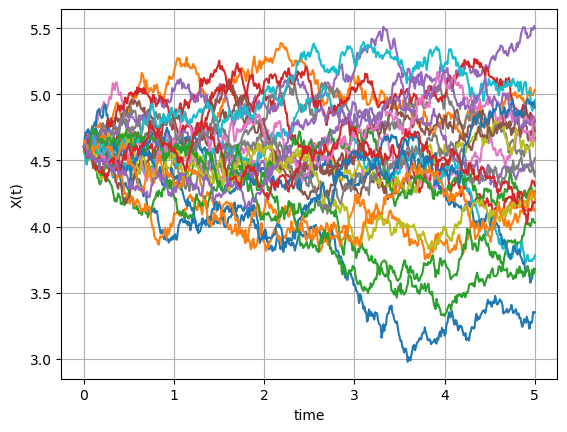

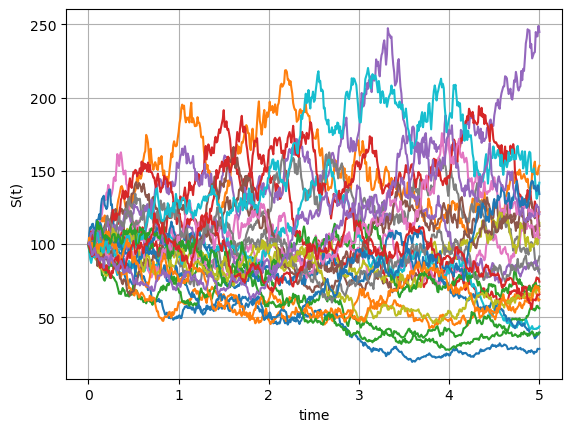

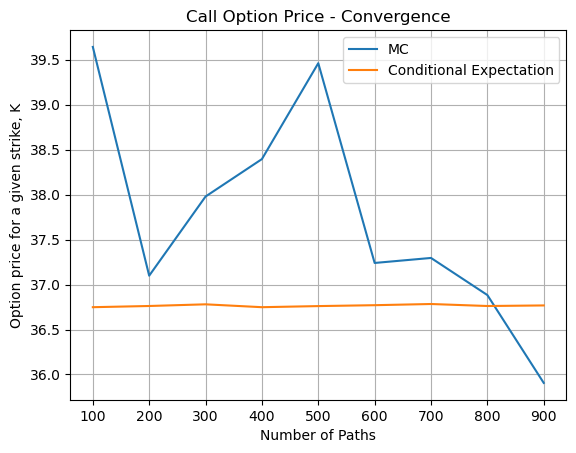

In [59]:
def mainCalculation():
    NoOfPaths = 25
    NoOfSteps = 500
    T = 5
    muJ = 0.3
    sigmaJ = 0.005

    S0 = 100
    r = 0.01
    Paths = GeneratePaths(NoOfPaths,NoOfSteps,S0, T,muJ,sigmaJ,r)
    timeGrid = Paths["time"]
    X = Paths["X"]
    S = Paths["S"]

    plt.figure(1)
    plt.plot(timeGrid, np.transpose(X))
    plt.grid()
    plt.xlabel("time")
    plt.ylabel("X(t)")

    plt.figure(2)
    plt.plot(timeGrid, np.transpose(S))
    plt.grid()
    plt.xlabel("time")
    plt.ylabel("S(t)")

    K = 80 
    CP = OptionType.CALL

    NGrid = range(100,1000,100)
    NoOfRuns = len(NGrid)

    resultMC = np.zeros(NoOfRuns)
    resultCondExp = np.zeros(NoOfRuns)



    for (i,N) in enumerate(NGrid):
        print(N)
        Paths = GeneratePaths(N, NoOfSteps, S0, T, muJ, sigmaJ,r)
        timeGrid = Paths["time"]
        S = Paths["S"]
        mc_price = EUOptionPriceFromMCPaths(CP,S[:,-1],K,T,r)
        resultMC[i] = float(mc_price)
        
        J = Paths["J"]

        cond_exp_price = CallOption_CondExpectation(N,T,S0,K,J,r)
        resultCondExp[i] = float(cond_exp_price)
        
    plt.figure(3)
    plt.plot(NGrid,resultMC)
    plt.plot(NGrid, resultCondExp)
    plt.legend(["MC", "Conditional Expectation"])
    plt.title("Call Option Price - Convergence")
    plt.xlabel("Number of Paths")
    plt.ylabel("Option price for a given strike, K")
    plt.grid()

mainCalculation()
    

From the results we can see that using conditional expectation through the simulation greatly improves the convergence of the simualtion (the conditional simulation almost being a flat line)